# KNN - K Nearest Neighbours

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import math

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, GridSearchCV

### KNN in classification problem

In [8]:
# load the churn dataset AFTER recoding from a pickle file

churn_train_encoded = pd.read_pickle('data/churn_train_encoded.pkl')
churn_test_encoded = pd.read_pickle('data/churn_test_encoded.pkl')

churn_train_encoded.head()

,customer_id,customer_age,customer_number_of_dependents,customer_education,customer_salary_range,customer_relationship_length,customer_available_credit_limit,total_products,period_inactive,contacts_in_last_year,...,average_utilization,customer_gender_M,customer_gender_Unknown,customer_civil_status_Married,customer_civil_status_Single,customer_civil_status_Unknown,credit_card_classification_Gold,credit_card_classification_Platinum,credit_card_classification_Silver,account_status_1
4694,799562,50.0,2.0,2.0,1.0,37.0,13384.0,1.0,3.0,2.0,...,0.000,0,0,1,0,0,0,0,1,0
1263,282706,52.0,1.0,2.0,5.0,36.0,31945.0,4.0,3.0,5.0,...,0.050,1,0,0,0,0,0,0,0,0
4427,837683,46.0,3.0,1.0,3.0,36.0,5489.0,5.0,1.0,2.0,...,0.217,1,0,0,1,0,0,0,0,0
8746,384742,53.0,5.0,0.0,4.0,48.0,9517.0,6.0,1.0,0.0,...,0.196,1,0,1,0,0,0,0,0,0
4386,618362,59.0,0.0,4.0,2.0,53.0,4241.0,3.0,2.0,3.0,...,0.000,1,0,1,0,0,0,0,0,0


In [10]:
# our goal will be to predict the account_status based on a set of characteristics

# how to choose the number of nearest neighbors?
# let's start with K = sqrt(n)

# basic way to find the number of optimal k is sqrt of observations

math.sqrt(len(churn_train_encoded))

84.19026071939675

In [14]:
# lets use 85 (since the classification is based on 'voting' it is better to choose
# an odd number of neighbours)

X_train = churn_train_encoded.drop(['account_status_1', 'customer_id'], axis = 1)
y_train = churn_train_encoded['account_status_1']


# Key parameters of KNeighborsClassifier:
# - n_neighbors: Number of neighbors - default value is 5.
# - weights: weighting of neighbors in prediction:
#           'uniform' (all points in the neighborhood have the same weight) - default,
#           'distance' (points weighted by the inverse distance - 
#                       closer ones have a bigger impact on the result).
# - p: power value for the Minkowski distance metric

# for p = 1 city distance (Manhattan/city distance - lambda)
# for p = 2 Euclidean distance.
# de facto for any p the Minkowski distance with power of p is used.

# KNN with 85 neighbors, Euclidean distance, equal weights

knn_churn1 = KNeighborsClassifier(n_neighbors = 85)
knn_churn1.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=85)

In [16]:
# calculate the fitted values - prediction on training sample

''' Here validate sample needs to be used X_validate to check model accuracy
as it is wrong to check model based on the same sample it was trained. '''

churn_knn_fitted = knn_churn1.predict(X_train)

# y_validate could be an alternative for classification report
print(classification_report(y_train, churn_knn_fitted))

# accuracy quite high, but "negatives" (0) are much better predicted (specificity)

# Balanced accuracy barely around 65% (macro avg recall)

              precision    recall  f1-score   support

           0       0.88      0.98      0.93      5949
           1       0.71      0.30      0.42      1139

    accuracy                           0.87      7088
   macro avg       0.80      0.64      0.67      7088
weighted avg       0.85      0.87      0.84      7088



In [18]:
# lets see how it looks in the test sample

X_test = churn_test_encoded.drop(['account_status_1', 'customer_id'], axis = 1)
y_test = churn_test_encoded['account_status_1']

churn_knn_predictions = knn_churn1.predict(X_test)

# classification report
print(classification_report(y_test, churn_knn_predictions))

# comparable result

              precision    recall  f1-score   support

           0       0.88      0.98      0.93      2551
           1       0.74      0.33      0.45       488

    accuracy                           0.87      3039
   macro avg       0.81      0.65      0.69      3039
weighted avg       0.86      0.87      0.85      3039



In [20]:
# let's see what a different number of neighbors will change

# assume k = 3

knn_churn2 = KNeighborsClassifier(n_neighbors = 3)
knn_churn2.fit(X_train, y_train)

churn_knn_fitted2 = knn_churn2.predict(X_train)
churn_knn_predictions2 = knn_churn2.predict(X_test)

print('Results in the training sample:')
print(classification_report(y_train, churn_knn_fitted2))
print('------------------------------------------')
print('Results in the test sample:')
print(classification_report(y_test, churn_knn_predictions2))

# here is a clear difference between the training and test sample
# which suggests an overfitting problem

# look for the optimal value of parameter k using cross-validation

Results in the training sample:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      5949
           1       0.83      0.71      0.77      1139

    accuracy                           0.93      7088
   macro avg       0.89      0.84      0.86      7088
weighted avg       0.93      0.93      0.93      7088

------------------------------------------
Results in the test sample:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      2551
           1       0.68      0.58      0.63       488

    accuracy                           0.89      3039
   macro avg       0.80      0.76      0.78      3039
weighted avg       0.88      0.89      0.89      3039



## Hyperparameter Tuning

In [23]:
# define the range of k values using odd numbers from 1 to 99

k_values = list(range(1, 99, 2))

# create an object with validation definition

cv5 = KFold(
    n_splits = 5,
    shuffle = True,
    random_state = 123
)

# remember that in KNN it works well to scale all variables to the range 0-1,
# which is NOT done automatically!

# here MinMaxScaler() will help us with this, which uses range (min-max) standardization

# define it as a pipeline, so that it is done correctly, and independently
# in each iteration of cross-validation

knn_pipeline = Pipeline(
    [
        ('scaler', MinMaxScaler()), # scaling of data
        ('knn', KNeighborsClassifier()) # KNN classifier
    ]
)

# define a grid of hyperparameters to search
param_grid = {
    'knn__n_neighbors': k_values, # number of neighbours
    # check if the method of weighing neighbors has an impact on the result
    'knn__weights': ['uniform', 'distance']
}

# define GridSearchCV object
knn_grid_search = GridSearchCV(
    knn_pipeline,
    param_grid,
    cv = cv5,
    scoring = 'roc_auc',
    n_jobs = -1
)

In [25]:
knn_grid_search.fit(X_train, y_train)

print('Best parameters:', knn_grid_search.best_params_)
print('Best AUROC value:', knn_grid_search.best_score_)

Best parameters: {'knn__n_neighbors': 25, 'knn__weights': 'distance'}
Best AUROC value: 0.8567300090576457


In [37]:
# knn_grid_search.cv_results_

In [41]:
knn_grid_search_df = pd.DataFrame(knn_grid_search.cv_results_)

knn_grid_search_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__n_neighbors,param_knn__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.019613,0.000800,0.188749,0.001020,1,uniform,"{'knn__n_neighbors': 1, 'knn__weights': 'unifo...",0.685831,0.684827,0.679276,0.703681,0.675279,0.685779,0.009736,97
1,0.014715,0.004931,0.137416,0.063786,1,distance,"{'knn__n_neighbors': 1, 'knn__weights': 'dista...",0.685831,0.684827,0.679276,0.703681,0.675279,0.685779,0.009736,97
2,0.010264,0.000805,0.059408,0.003864,3,uniform,"{'knn__n_neighbors': 3, 'knn__weights': 'unifo...",0.785572,0.770680,0.781915,0.755571,0.774859,0.773719,0.010465,96
3,0.010608,0.001747,0.060241,0.003986,3,distance,"{'knn__n_neighbors': 3, 'knn__weights': 'dista...",0.790180,0.777077,0.786997,0.761210,0.780002,0.779093,0.010100,95
4,0.012907,0.002959,0.059438,0.006304,5,uniform,"{'knn__n_neighbors': 5, 'knn__weights': 'unifo...",0.826343,0.803205,0.815879,0.795210,0.807274,0.809582,0.010706,94


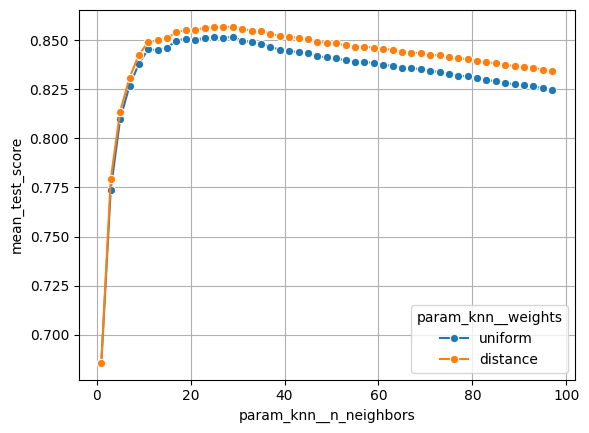

In [49]:
sns.lineplot(
    x = knn_grid_search_df['param_knn__n_neighbors'],
    y = knn_grid_search_df['mean_test_score'],
    hue = knn_grid_search_df['param_knn__weights'],
    marker = 'o'
)
plt.grid()
# you can see that in general "distance" weighting works better (higher AUROC) 

In [51]:
# the resulting object from validation can be directly used
# to get a prediction on a new data

y_pred_probs = knn_grid_search.predict_proba(X_test)

# you can also extract the best model as a separate object
best_knn = knn_grid_search.best_estimator_
y_pred_probs2 = best_knn.predict_proba(X_test)
# works the same as knn_grid_search.predict()

# results will be identical
print(np.array_equal(y_pred_probs, y_pred_probs2))

# True -> values are identical

True


In [57]:
best_knn = knn_grid_search.best_estimator_

y_predictions_knn = best_knn.predict(X_test)

In [59]:
print(classification_report(y_test, y_predictions_knn))

              precision    recall  f1-score   support

           0       0.87      0.99      0.93      2551
           1       0.80      0.25      0.38       488

    accuracy                           0.87      3039
   macro avg       0.84      0.62      0.65      3039
weighted avg       0.86      0.87      0.84      3039



## KNN in Regression Problem

In [64]:
# import the train and test data prepared before and stored in a pickle file

with open('data/houses_prepared_encoded.pkl', 'rb') as f:
    houses_train_encoded = pickle.load(f)
    houses_test_encoded = pickle.load(f)

houses_test_encoded.head()

,Order,PID,Lot_Frontage,Lot_Area,Lot_Shape,Land_Slope,Overall_Qual,Overall_Cond,Year_Built,Year_Remod_Add,...,Sale_Type_New,Sale_Type_Other,Sale_Type_WD,Sale_Condition_Family,Sale_Condition_Normal,Sale_Condition_Other,Sale_Condition_Partial,Land_Contour_HLS,Land_Contour_Low,Land_Contour_Lvl
0,1,526301100,141,31770,1.0,0.0,4.0,5.0,1960,1960,...,0,0,1,0,1,0,0,0,0,1
1,2,526350040,80,11622,0.0,0.0,5.0,4.0,1961,1961,...,0,0,1,0,1,0,0,0,0,1
2,3,526351010,81,14267,1.0,0.0,4.0,4.0,1958,1958,...,0,0,1,0,1,0,0,0,0,1
3,4,526353030,93,11160,0.0,0.0,3.0,5.0,1968,1968,...,0,0,1,0,1,0,0,0,0,1
4,5,527105010,74,13830,1.0,0.0,5.0,5.0,1997,1998,...,0,0,1,0,1,0,0,0,0,1


In [66]:
# for regression problems KNeighborsRegressor() is used

# Its key parameters are analogous to those in the classifier:
# - n_neighbors: Number of neighbors - default value is 5.
# - weights: weighting of neighbors in prediction:
#            'uniform' (all points in the neighborhood have the same weights) - default,
#            'distance' (points weighted by the inverse distance
#                       - closer ones have a bigger impact on the result).
# - p: power value for the Minkowski distance metric.

# for p=1 city distance (Manhattan/city distance)
# for p=2 Euclidean distance.
# de facto for any p the Minkowski distance with a power of p is used.

# example application on the 'houses' data

X_train = houses_train_encoded.drop(columns = ['Order', 'PID', 'Sale_Price'])
y_train = houses_train_encoded['Sale_Price']

X_test = houses_test_encoded.drop(columns = ['Order', 'PID', 'Sale_Price'])

# we initialize the KNN algorithm for regression
knn_houses = KNeighborsRegressor()

# Model fitting
knn_houses.fit(X_train, y_train)

# prediction
y_pred = knn_houses.predict(X_test)

<Axes: ylabel='Count'>

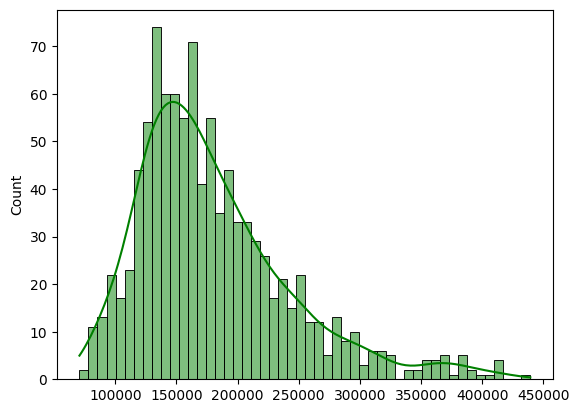

In [68]:
sns.histplot(y_pred, bins = 50, kde = True, color = 'green')

In [76]:
y_pred_df = pd.DataFrame(y_pred)

y_pred_df.head()

,0
0,157024.8
1,143480.0
2,172480.0
3,247730.2
4,188660.0
